In [0]:
pip install keras --upgrade

     |████████████████████████████████| 378kB 3.4MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-22j7o45k
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-22j7o45k
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=100e773398ecccec925ecf812facf068b0ab8fb9eda03556e89736230702a763
  Stored in directory: /tmp/pip-ephem-wheel-cache-knvl5g6t/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam, Nadam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback, TensorBoard
from keras_contrib.callbacks import CyclicLR
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, load_model

import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display

import numpy as np
import pandas as pd
import glob
import math
import cv2
import os

Using TensorFlow backend.


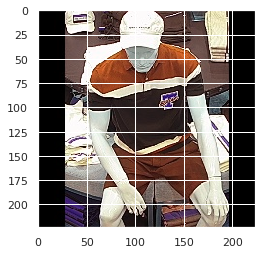

In [0]:
img_file = '/content/drive/My Drive/hvc_data/resized/1111.jpg'
img = cv2.imread(img_file)
img = cv2.resize(img, (0,0), fx=1, fy=1)
plt.imshow(img)

In [0]:
input_shape = img.shape
df = pd.read_csv('/content/drive/My Drive/hvc_data/hvc_annotations.csv')
del df["filename"] # remove unwanted column
features = ['gender', 'imagequality', 'age', 'weight', 'carryingbag', 'footwear', 'emotion', 'bodypose']

In [0]:
num_units = dict(zip(features, [len(df[feature].unique()) for feature in features]))

In [0]:
# one hot encoding of labels
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)
one_hot_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  bias_initializer='he_normal',
                  kernel_regularizer=l2(1e-4),
                  bias_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:

def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def resnet_v2(input_shape, depth):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connecters is identity.
    At the beginning of each stage, theers ture map size is halved (downsampled)
    by a convolutional layer with striders , while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = y

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

Training parameters


                |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
      Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
                |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
      ResNet20  | 3 (2)| 92.16     | 91.25     |           |           | 35 ()
      ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
      ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
      ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
      ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
      ResNet164 |27(18)|           | 94.07     |           | 94.54     | ()
      ResNet1001| (111)|           | 92.39     |           | 95.08+-.14| ()

In [0]:
batch_size = 8  # orig paper trained all networks with batch_size=128

# CLR enable
is_clr_enabled = True

# LR range finder enable
is_lr_finder = False

epochs = 160

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [0]:
def build_neck(x):
  return Dense(512, activation="relu")(x)

def build_tower(x):
  x = Dropout(0.2)(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.3)(x)
  return Dense(128, activation="relu")(x)

def build_head(name, x):
    return Dense(num_units[name], activation="softmax", name=f"{name}_output")(x)

def build_predictor(model):

  neck = build_neck(model.output)

  gender = build_head("gender", build_tower(neck))
  image_quality = build_head("imagequality", build_tower(neck))
  age = build_head("age", build_tower(neck))
  weight = build_head("weight", build_tower(neck))
  carryingbag = build_head("carryingbag", build_tower(neck))
  footwear = build_head("footwear", build_tower(neck))
  emotion = build_head("emotion", build_tower(neck))
  pose = build_head("bodypose", build_tower(neck))

  return Model(inputs=model.input, outputs=[gender, image_quality, age, weight, carryingbag, footwear, pose, emotion])

Creating new model or Loading old model

In [0]:
create_new = True
if create_new:
  if version == 2:
      model = resnet_v2(input_shape=input_shape, depth=depth)
  else:
      model = resnet_v1(input_shape=input_shape, depth=depth)
  
  model = build_predictor(model)

  model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.001, nesterov=True),
              metrics=['accuracy'])

else:
  model = load_model('/content/drive/My Drive/baseline_model_path/hvc_ResNet20v2_model.120.h5')

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
__________

Model checkpoint

In [0]:
# Prepare model model saving directory.
save_dir = '/content/drive/My Drive/saved_models_current'
model_name = 'hvc_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

Batch history callback

In [0]:
class BatchLossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs)
batch_loss = BatchLossHistory()

CLR callback

In [0]:
validation_split = 0.2
num_samples = len(one_hot_df)
iterations_per_epoch = round(num_samples * (1 - validation_split) / batch_size)
step_size = iterations_per_epoch
base_lr = 1.5 * 1e-4
max_lr = 0.9 * 1e-3
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr,
                      step_size=step_size, mode='triangular')

LR Scheduler

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

LR Reducer

In [0]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                              cooldown=0,
                              patience=5,
                              min_lr=0.5e-6)

Tensorboard

In [0]:
logdir= '/content/drive/My Drive/log_dir'
tensorboard = TensorBoard(log_dir=logdir)

In [0]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [0]:
lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-2, 
                    steps_per_epoch=step_size, 
                    epochs=2)

In [0]:
if is_lr_finder:
  callbacks = [checkpoint, batch_loss, lr_finder]
elif is_clr_enabled:
  callbacks = [checkpoint, clr, batch_loss, tensorboard]
else:
  callbacks = [checkpoint, lr_reducer, lr_scheduler, tensorboard]

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    '''
    p : the probability that random erasing is performed
    s_l, s_h : minimum / maximum proportion of erased area against input image
    r_1, r_2 : minimum / maximum aspect ratio of erased area
    v_l, v_h : minimum / maximum value for erased area
    pixel_level : pixel-level randomization for erased area
    '''
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c
        return input_img
    return eraser

Generators

In [0]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,            # set input mean to 0 over the dataset
    samplewise_center=False,             # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,                 # apply ZCA whitening
    zca_epsilon=1e-06,                   # epsilon for ZCA whitening
    rotation_range=0,                    # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.1,               # randomly shift images horizontally
    height_shift_range=0.1,              # randomly shift images vertically
    shear_range=0.,                      # set range for random shear
    zoom_range=0.,                       # set range for random zoom
    channel_shift_range=0.,              # set range for random channel shifts
    fill_mode='nearest',                 # set mode for filling points outside the input boundaries
    cval=0.,                             # value used for fill_mode = "constant"
    horizontal_flip=True,                # randomly flip images
    vertical_flip=False,                 # randomly flip images
    rescale=None,                        # set rescaling factor (applied before any other transformation)
    preprocessing_function=get_random_eraser(v_l=0, 
                                             v_h=1, 
                                             s_l=0.02,
                                             s_h=0.1),  # set function that will be applied on each input
    data_format=None,                    # image data format, either "channels_first" or "channels_last"
    validation_split=validation_split)                # fraction of images reserved for validation (strictly between 0 and 1)

In [0]:
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [0]:
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]

        augmented_img = []
        for _, item in items.iterrows():
          img = cv2.imread(f'/content/drive/My Drive/hvc_data/{item["image_path"]}')
          # img = get_random_eraser(v_l=0, v_h=1, s_l=0.02, s_h=0.1)(img)
          augmented_img.append(img)

        image = np.stack(augmented_img)
        target = {
            "gender_output": items[_gender_cols_].values,
            "imagequality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "carryingbag_output": items[_carryingbag_cols_].values,
            "bodypose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=validation_split)

In [0]:
# create train and validation data generators
train_generator = PersonDataGenerator(train_df, batch_size=batch_size)
validation_generator = PersonDataGenerator(train_df, batch_size=batch_size, shuffle=False)

In [0]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/My Drive/log_dir"

In [0]:
# Fit the model on the batches generated by datagen.flow().
model_info = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    use_multipocessing=True,
                    epochs=epochs,
                    verbose=1,
                    workers=4,
                    callbacks=callbacks)




Epoch 1/160
1357/1357 [==============================] - 273s 201ms/step - loss: 8.6175 - gender_output_loss: 0.6866 - imagequality_output_loss: 1.0155 - age_output_loss: 1.4725 - weight_output_loss: 1.0425 - carryingbag_output_loss: 0.9686 - footwear_output_loss: 1.0346 - bodypose_output_loss: 0.9517 - emotion_output_loss: 0.9652 - gender_output_accuracy: 0.5685 - imagequality_output_accuracy: 0.5242 - age_output_accuracy: 0.3761 - weight_output_accuracy: 0.6128 - carryingbag_output_accuracy: 0.5241 - footwear_output_accuracy: 0.4766 - bodypose_output_accuracy: 0.6063 - emotion_output_accuracy: 0.7022 - val_loss: 8.0261 - val_gender_output_loss: 0.6421 - val_imagequality_output_loss: 0.9688 - val_age_output_loss: 1.4225 - val_weight_output_loss: 0.9745 - val_carryingbag_output_loss: 0.9052 - val_footwear_output_loss: 0.9408 - val_bodypose_output_loss: 0.9129 - val_emotion_output_loss: 0.9164 - val_gender_output_accuracy: 0.6277 - val_imagequality_output_accuracy: 0.5534 - val_age_o

In [0]:
summary = {}
for e in tf.compat.v1.train.summary_iterator('/content/drive/My Drive/log_dir/events.out.tfevents.1577523746.390b84bba403'):
    for v in e.summary.value:
        if v.tag not in summary:
            summary[v.tag] = []
        summary[v.tag].append(v.simple_value)
summary_df = pd.DataFrame.from_records(summary)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [0]:
summary_df.to_html('df.html')

In [0]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(summary_df)

,age_output_accuracy,age_output_loss,bodypose_output_accuracy,bodypose_output_loss,carryingbag_output_accuracy,carryingbag_output_loss,emotion_output_accuracy,emotion_output_loss,footwear_output_accuracy,footwear_output_loss,gender_output_accuracy,gender_output_loss,imagequality_output_accuracy,imagequality_output_loss,loss,lr,val_age_output_accuracy,val_age_output_loss,val_bodypose_output_accuracy,val_bodypose_output_loss,val_carryingbag_output_accuracy,val_carryingbag_output_loss,val_emotion_output_accuracy,val_emotion_output_loss,val_footwear_output_accuracy,val_footwear_output_loss,val_gender_output_accuracy,val_gender_output_loss,val_imagequality_output_accuracy,val_imagequality_output_loss,val_loss,val_weight_output_accuracy,val_weight_output_loss,weight_output_accuracy,weight_output_loss
0,0.376105,1.472462,0.606301,0.951657,0.524134,0.968598,0.702192,0.965234,0.476603,1.034624,0.568534,0.686650,0.524226,1.015548,8.617464,0.00090,0.401713,1.422493,0.619749,0.912888,0.565402,0.905163,0.712693,0.916383,0.571021,0.940829,0.627671,0.642126,0.553427,0.968762,8.026105,0.638172,0.974516,0.612841,1.042485
1,0.385317,1.437054,0.618644,0.923048,0.556743,0.922121,0.712417,0.927705,0.559046,0.947732,0.624263,0.636733,0.544768,0.977443,8.250859,0.00015,0.398029,1.404804,0.619749,0.901887,0.569731,0.896157,0.712693,0.898747,0.583088,0.911708,0.650700,0.610354,0.555453,0.958644,7.842109,0.638080,0.966212,0.636330,0.998982
2,0.389923,1.421641,0.619289,0.912351,0.559875,0.913896,0.712417,0.922812,0.569915,0.928998,0.634119,0.627780,0.545136,0.971678,8.167266,0.00090,0.394989,1.410709,0.619842,0.892503,0.571021,0.893542,0.712693,0.899769,0.589720,0.901246,0.653740,0.608082,0.553427,0.948397,7.869802,0.638172,0.968153,0.637251,0.988173
3,0.393423,1.423520,0.619565,0.896536,0.561717,0.909072,0.712509,0.915731,0.579956,0.915696,0.644989,0.615039,0.551769,0.961921,8.101638,0.00015,0.399595,1.394852,0.619749,0.871188,0.575811,0.888046,0.712693,0.890626,0.595615,0.886178,0.672531,0.588201,0.555730,0.938394,7.686843,0.638172,0.962358,0.638357,0.984352
4,0.396094,1.412793,0.619749,0.892374,0.563467,0.908282,0.712601,0.906942,0.586496,0.905992,0.662583,0.604369,0.547623,0.953255,8.046652,0.00090,0.400700,1.394503,0.621131,0.862886,0.568349,0.894638,0.712693,0.891834,0.598102,0.882022,0.675940,0.584515,0.554256,0.930147,7.650537,0.638265,0.962102,0.637528,0.982979
5,0.394713,1.414441,0.620671,0.877847,0.561717,0.903734,0.712786,0.906228,0.591839,0.897891,0.665899,0.597611,0.548360,0.949749,8.007130,0.00015,0.400884,1.387024,0.620947,0.845942,0.579679,0.884169,0.712693,0.884617,0.603906,0.872516,0.690678,0.569875,0.560888,0.922685,7.712793,0.638080,0.960589,0.637159,0.980129
6,0.396831,1.408302,0.623250,0.864171,0.566323,0.902119,0.712693,0.905456,0.595615,0.888644,0.674834,0.592337,0.547163,0.941316,7.960183,0.00090,0.398950,1.396632,0.630343,0.841327,0.582351,0.886917,0.712693,0.886788,0.607498,0.864854,0.691968,0.572091,0.548176,0.932102,7.571835,0.638172,0.960047,0.637804,0.978442
7,0.399318,1.407970,0.627579,0.852398,0.571297,0.897557,0.712693,0.903627,0.599024,0.881834,0.680085,0.581605,0.550940,0.939522,7.920396,0.00015,0.400884,1.380982,0.639278,0.813347,0.585391,0.877518,0.712693,0.881975,0.613670,0.856815,0.701087,0.556901,0.563559,0.908341,7.586614,0.638172,0.957590,0.637896,0.976651
8,0.399042,1.397729,0.632093,0.841983,0.570007,0.892350,0.712786,0.901022,0.603169,0.871935,0.685796,0.579551,0.553335,0.934648,7.873733,0.00090,0.399779,1.382284,0.626750,0.833576,0.582167,0.883323,0.712693,0.886911,0.616710,0.853870,0.702192,0.557547,0.556374,0.925737,7.677677,0.638172,0.959690,0.637251,0.975387
9,0.401345,1.397557,0.634119,0.836223,0.569363,0.894219,0.712601,0.899871,0.603814,0.870809,0.686164,0.578028,0.558125,0.930054,7.856598,0.00015,0.405766,1.373170,0.644068,0.793827,0.586957,0.876254,0.712693,0.878231,0.620855,0.844546,0.705416,0.552369,0.565402,0.900830,7.507185,0.638172,0.954463,0.637804,0.970876


In [0]:
summary_df[['val_' + feature + '_output_accuracy' for feature in features]].iloc[-1]

val_gender_output_accuracy          0.993368
val_imagequality_output_accuracy    0.867170
val_age_output_accuracy             0.761699
val_weight_output_accuracy          0.820836
val_carryingbag_output_accuracy     0.891581
val_footwear_output_accuracy        0.898858
val_emotion_output_accuracy         0.815678
val_bodypose_output_accuracy        0.987380
Name: 121, dtype: float64

In [0]:
summary_df[['val_' + feature + '_output_accuracy' for feature in features]].max()

val_gender_output_accuracy          0.993368
val_imagequality_output_accuracy    0.867170
val_age_output_accuracy             0.761699
val_weight_output_accuracy          0.820836
val_carryingbag_output_accuracy     0.891581
val_footwear_output_accuracy        0.898858
val_emotion_output_accuracy         0.820284
val_bodypose_output_accuracy        0.987380
dtype: float64

In [0]:
summary_df[['val_' + feature + '_output_loss' for feature in features]].min()

val_gender_output_loss          0.039912
val_imagequality_output_loss    0.390685
val_age_output_loss             0.682972
val_weight_output_loss          0.479791
val_carryingbag_output_loss     0.323857
val_footwear_output_loss        0.293497
val_emotion_output_loss         0.469514
val_bodypose_output_loss        0.074374
dtype: float64

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,1,figsize=(15,5))
    # summarize history for loss
    axs.plot(range(1, len(model_history['loss'])  + 1), model_history['loss'])
    axs.plot(range(1, len(model_history['val_loss']) + 1), model_history['val_loss'])
    axs.set_title('Model Loss')
    axs.set_ylabel('Loss')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1, len(model_history['loss']) + 1), len(model_history['loss']))
    axs.legend(['train', 'val'], loc='best')
    plt.savefig('overall_acc.jpg')

In [0]:
def plot_feature_accuracy_history(model_history):
  fig, axs = plt.subplots(1, len(features), figsize=(30, 5))
  for i, feature in enumerate(features):
      axs[i].plot(range(1,len(model_history[f'{feature}_output_accuracy'])+1),model_history[f'{feature}_output_accuracy'])
      axs[i].plot(range(1,len(model_history[f'val_{feature}_output_accuracy'])+1),model_history[f'val_{feature}_output_accuracy'])
      axs[i].set_title(feature)
      axs[i].set_ylabel('Accuracy')
      axs[i].set_xlabel('Epoch')
      axs[i].set_xticks(np.arange(1,len(model_history[f'{feature}_output_accuracy'])+1),len(model_history[f'{feature}_output_accuracy'])/10)
      axs[i].set_ylim([0.3, 1.0])
      axs[i].legend(['train', 'val'], loc='best')
  plt.savefig('class_acc.jpg')

In [0]:
def plot_feature_loss_history(model_history):
  fig, axs = plt.subplots(1, len(features), figsize=(30, 5))
  for i, feature in enumerate(features):
      axs[i].plot(range(1,len(model_history[f'{feature}_output_loss'])+1),model_history[f'{feature}_output_loss'])
      axs[i].plot(range(1,len(model_history[f'val_{feature}_output_loss'])+1),model_history[f'val_{feature}_output_loss'])
      axs[i].set_title(feature)
      axs[i].set_ylabel('Accuracy')
      axs[i].set_xlabel('Epoch')
      axs[i].set_xticks(np.arange(1, len(model_history[f'{feature}_output_loss'])+1),len(model_history[f'{feature}_output_loss'])/10)
      axs[i].set_ylim([0.0, 2.0])
      axs[i].legend(['train', 'val'], loc='best')
  plt.savefig('class_acc.jpg')

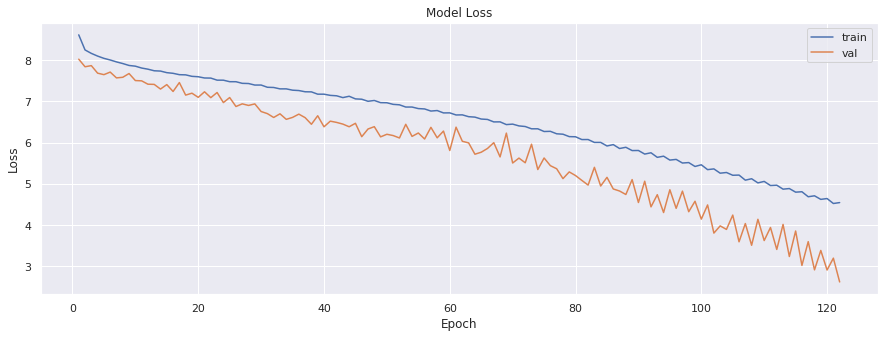

In [0]:
plot_model_history(summary)

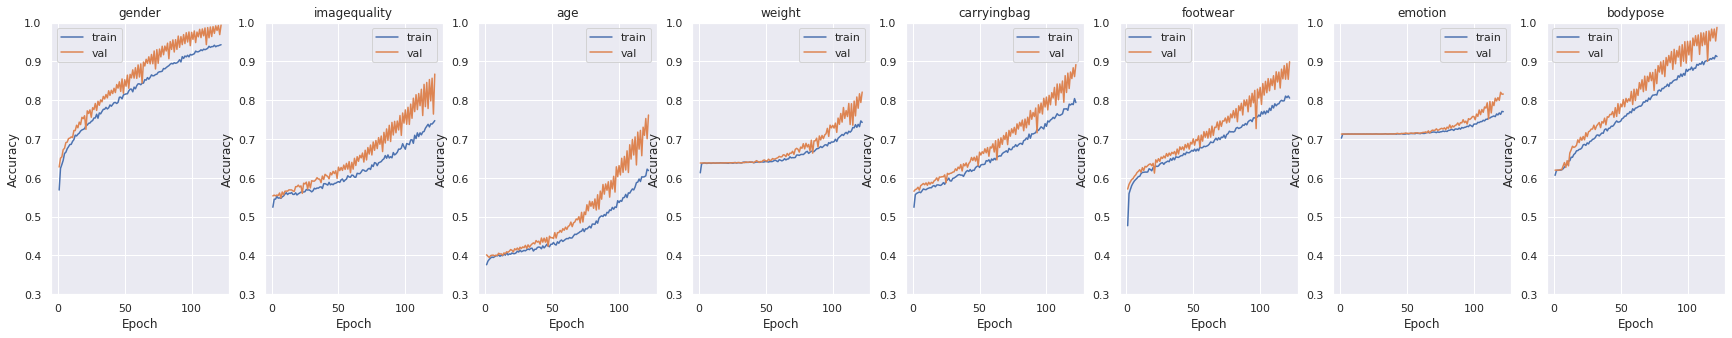

In [0]:
plot_feature_accuracy_history(summary)

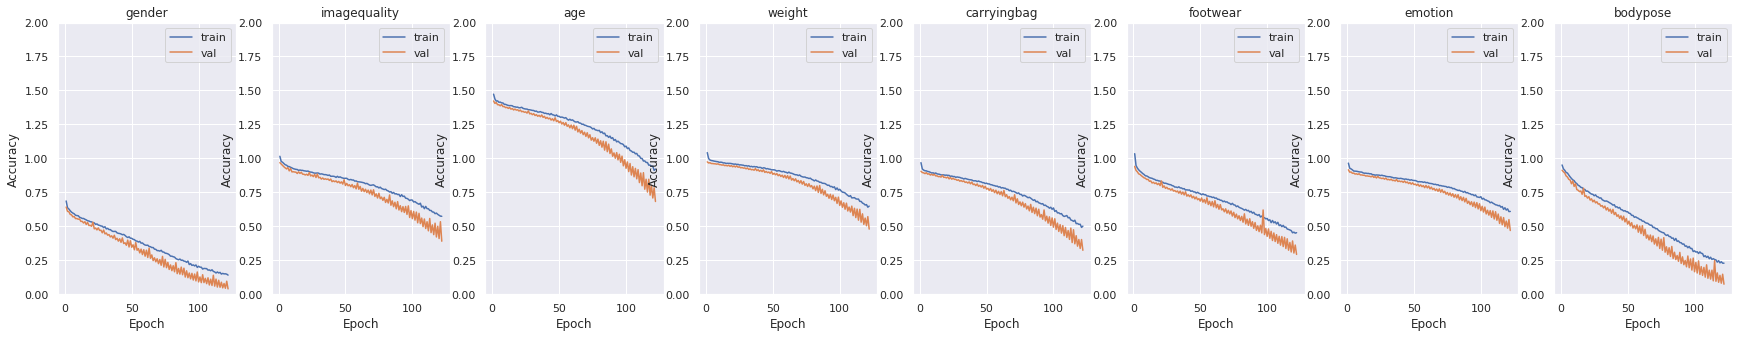

In [0]:
plot_feature_loss_history(summary)

In [0]:
plt.figure(figsize=(15, 5))
plt.xscale('log')
sns.lineplot(lr_finder.history['lr'], pd.Series(lr_finder.history['loss']).rolling(30).mean())
plt.axvline(x=1.5 * 1e-4, c='r', label='base_lr')
plt.axvline(x=0.9 * 1e-3, c='r', label='max_lr')
plt.savefig('lr-range.jpg')